<a href="https://colab.research.google.com/github/lapshinaaa/applied-statistics-tasks/blob/main/AS4_Nonparametric.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>
<img src="https://raw.githubusercontent.com/FUlyankin/r_probability/master/end_seminars_2020/sem08/real_expect.png" width="500">

# Nonparametric Statistics
</center>

## Task 1 (Crashing Mann–Whitney U test)

Тест Манна-Уитни [довольно легко сломать.](https://habr.com/ru/companies/avito/articles/709596/)

Главная предпосылка теста заключается в том, что распределение не меняется, но у него происходит сдвиг.

\begin{equation*}
    \begin{aligned}
    & H_0: F_X(x) = F_Y(y) \\
    & H_A: F_X(x) = F_Y(y + m), m \ne 0
    \end{aligned}
\end{equation*}


<center>
<img src='https://raw.githubusercontent.com/hse-econ-data-science/andan_2023/main/sem12_more_ab/mw.png' align='center' width="300x">
</center>

Воспользуемся этим.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts
from collections import defaultdict
from sklearn.metrics import roc_curve, auc

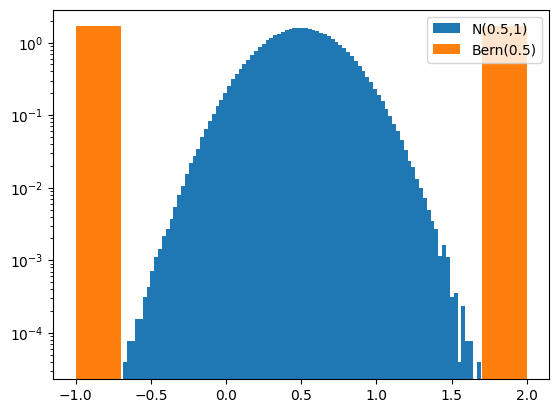

In [1]:
n_obs = 10**6
x = sts.norm(0.5, 0.25).rvs(n_obs)
y = 3*sts.bernoulli(0.5).rvs(n_obs) - 1

# polarized opinions as a result of AB test

plt.hist(x, bins=100, density=True, label='N(0.5,1)');
plt.hist(y, density=True, label='Bern(0.5)', log=True);
plt.legend();

In [2]:
# Mann-Whitney says there's no change where there obviously is
_, pval = sts.mannwhitneyu(x, y, alternative='two-sided')
pval

np.float64(0.8015380886349799)

In [4]:
# Kolmogorod-Smirnov test is noticing the shift
sts.ks_2samp(x, y)

KstestResult(statistic=np.float64(0.500101), pvalue=np.float64(0.0), statistic_location=np.float64(-1.0), statistic_sign=np.int8(-1))

__а) [5 баллов]__ Проведите для подобной ситуации с поляризацией больше испытаний. Постройте для теста Манна-Уитни и для KS-теста ROC-кривые.

In [7]:
def plot_pvalue_distribution(dict_pvalues):
    xseq = np.linspace(0, 1, 1000)

    for key, pvalues in dict_pvalues.items():
        yseq = [np.mean(pvalues < x) for x in xseq]
        plt.plot(xseq, yseq, label=key)

    plt.plot([0, 1], [0, 1], '--k', alpha=0.8)
    plt.title('Distribution p-value/ROC-curve', size=16)
    plt.xlabel('alpha', size=12)
    plt.ylabel('1 - beta', size=12)
    plt.legend(fontsize=12)
    plt.grid()

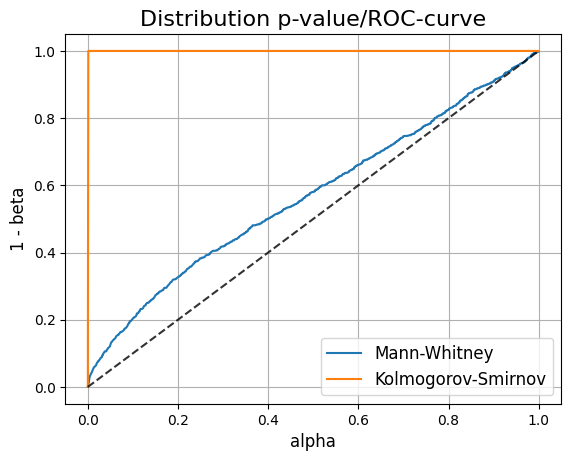

In [9]:
n_sim = 1000
sample_size = 500

dict_pvalues = defaultdict(list)
for _ in range(n_sim):

    x = sts.norm(0.5, 0.25).rvs(n_obs)
    y = 3*sts.bernoulli(0.5).rvs(n_obs) - 1

    _, pval_mw = sts.mannwhitneyu(x, y, alternative='two-sided')
    _, pval_ks = sts.ks_2samp(x, y)

    dict_pvalues['Mann-Whitney'].append(pval_mw)
    dict_pvalues['Kolmogorov-Smirnov'].append(pval_ks)

plot_pvalue_distribution(dict_pvalues)

As can be seen in the plot above, the Kolmogorov-Smirnov test clearly saw the distinction in the distribution immediately, unlike the Mann-Whitney one.

__б) [5 баллов]__ Придумайте ещё какой-нибудь пример, где тест Манна-Уитни сломается, а KS-тест нет. Нарисуйте для него ROC-кривые.

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ▬▬ι═══════  bzzzzzzzzzz
# will the code be with you

__в) [бонусные 5 баллов]__ Реализуйте [перестановочный тест](https://youtu.be/uKqsqAJtdzI) и с помощью симуляций продемонстрируйте, чето он обладает ровно такими же проблемами, как и тест Манна-Уитни.

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ▬▬ι═══════  bzzzzzzzzzz
# will the code be with you